In [ ]:
!pip install -r requirements.txt

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications import VGG16,ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.python.keras import backend as K
from tensorflow.python.util.tf_export import keras_export
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import os
import math
Image.MAX_IMAGE_PIXELS = None  
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from transformers import AutoTokenizer, BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder

d:\projects\jupiter_test\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.config.optimizer.set_jit(True)  ##ONLY FOR CUDA


# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPU, 1 Logical GPU


In [1]:
!tail 10 ./dataset/train.txt

==> ./dataset/train.txt <==
i feel really glad that i dont look like the celebrities out there that are so beautiful she told dr;joy
i have wanted to perhaps convey my feelings of a matter instead of my thoughts and have rejected it because i have thought feelings in the matter irrelevant;sadness
i moved away he said something that made me feel violent but its something i still cant make out;anger
i most days feel like if braeden and calvin are happy then it has been a successful day;joy
i feel so sympathetic empathetic towards them;love
i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up;sadness
i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree;sadness
i feel strong and good overall;joy
i feel like this was such a rude comment and im glad that t;anger
i know a lot but i feel so stupid because i can not portray it;sadness


tail: cannot open '10' for reading: No such file or directory


In [3]:
df_train = pd.read_csv("./dataset/train.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_test = pd.read_csv("./dataset/test.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_val = pd.read_csv("./dataset/val.txt", sep=";", header=None, names=['Text', 'Emotion'])


emotions = df_train['Emotion'].unique().tolist()


In [4]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions))

Some layers from the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream ta

In [5]:
def tokenize_text(text):
    return tokenizer(text,
                     padding='max_length',
                     truncation=True,
                     max_length=128)

tokenized_text_train = df_train['Text'].apply(tokenize_text)
tokenized_text_test = df_test['Text'].apply(tokenize_text)
tokenized_text_val = df_val['Text'].apply(tokenize_text)

In [6]:
def extract_features(series):
    input_ids = np.array([item['input_ids'] for item in series])
    attention_mask = np.array([item['attention_mask'] for item in series])
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

tokenized_train_np = extract_features(tokenized_text_train)
tokenized_test_np = extract_features(tokenized_text_test)
tokenized_val_np = extract_features(tokenized_text_val)

In [7]:
y_train = df_train['Emotion']
y_test = df_test['Emotion']
y_val = df_val['Emotion']

label_encoder = LabelEncoder()
label_encoder.fit(emotions)

y_train = tf.keras.utils.to_categorical(label_encoder.transform(y_train), num_classes=len(emotions))
y_test = tf.keras.utils.to_categorical(label_encoder.transform(y_test), num_classes=len(emotions))
y_val = tf.keras.utils.to_categorical(label_encoder.transform(y_val), num_classes=len(emotions))

emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [8]:
def plot_learning_curve(history, figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [9]:
batch_size = 8

train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train_np, y_train)).shuffle(len(df_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((tokenized_test_np, y_test)).shuffle(len(df_test)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((tokenized_val_np, y_val)).shuffle(len(df_val)).batch(batch_size)

In [10]:
optimizer=AdamW(weight_decay=0.2, learning_rate=3e-4, beta_1=0.99)
# optimizer = AdamW(weight_decay=0.01, learning_rate=1e-4, beta_1=0.99, clipvalue=1.0)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs = 5,
    # batch_size = 16,
    validation_data = val_ds,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

Epoch 1/5
2000/2000 [==============================] - 235s 112ms/step - loss: 8.1877 - accuracy: 0.1231 - val_loss: 8.0832 - val_accuracy: 0.1060
Epoch 2/5
2000/2000 [==============================] - 187s 93ms/step - loss: 8.1889 - accuracy: 0.1211 - val_loss: 8.0832 - val_accuracy: 0.1060
Epoch 3/5
2000/2000 [==============================] - 186s 93ms/step - loss: nan - accuracy: 0.1175 - val_loss: nan - val_accuracy: 0.0405


Loss:nan??????

In [15]:
model.save_weights('./model.keras')

In [39]:
model.load_weights('./model.keras')

In [13]:
y_test = np.array([label for _, label in test_ds.unbatch()])

pred_logits = model.predict(test_ds).logits
y_pred = tf.argmax(pred_logits, axis=1).numpy()

y_test_int = np.argmax(y_test, axis=1)

print("Shape of y_pred:", y_pred.shape)

250/250 [==============================] - 4s 17ms/step
Shape of y_pred: (2000,)


In [18]:
pred_logits

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

Classification Report:
              precision    recall  f1-score   support

           0       0.14      1.00      0.24       275
           1       1.00      0.00      0.00       224
           2       1.00      0.00      0.00       695
           3       1.00      0.00      0.00       159
           4       1.00      0.00      0.00       581
           5       1.00      0.00      0.00        66

    accuracy                           0.14      2000
   macro avg       0.86      0.17      0.04      2000
weighted avg       0.88      0.14      0.03      2000



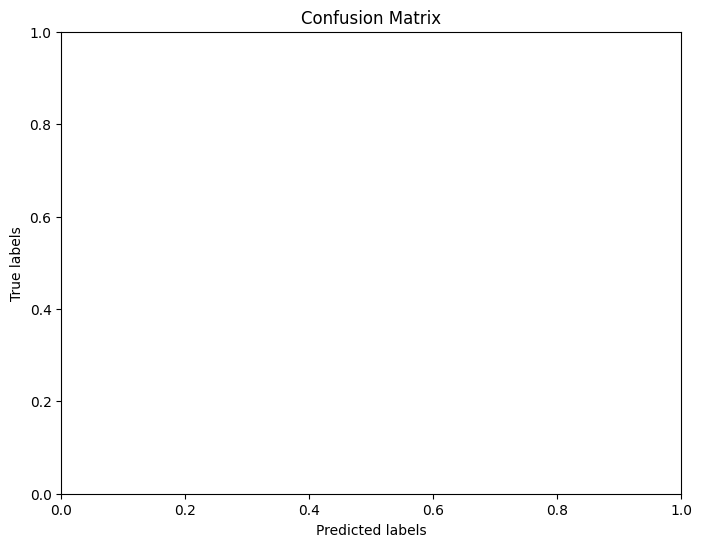

In [14]:
if len(y_pred.shape) == 1:
    y_pred_int = y_pred
else:
    y_pred_int = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_int, y_pred_int, zero_division=1))

plot_confusion_matrix(y_test_int, y_pred_int)